### Tensorflow imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

tf.get_logger().setLevel('ERROR')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Miscellaneous imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import shutil
import imghdr as ih
import csv

### Configuration

In [3]:
IMG_SIZE = 180
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
SEED = 670
NOISE_FACTOR = 0.5
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 10
NB_EPOCHS = 1000
PATIENCE_FACTOR = 0.4
PATIENCE = int(NB_EPOCHS * PATIENCE_FACTOR)

USE_GOOGLE_COLAB = False

PROJECT = "denoiser"

DATASET_DIR = "Livrable 2 - Dataset"
CHECKPOINTS_DIR = "checkpoints"

In [4]:
ROOT = "./"
if USE_GOOGLE_COLAB:
    from google.colab import drive

    drive.mount('/content/drive')
    ROOT = '/content/drive/MyDrive/A5 - Data Science/'

    !pip install git+https://github.com/paulgavrikov/visualkeras
    import visualkeras

### Dataset

In [5]:
def display_image(X, n, title=''):
    plt.figure(figsize=(8, 8))
    for images in X.take(1):
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow((images[i].numpy().astype("float")))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.title(title)
    plt.show()

In [6]:
def data_augmentation(img):
    img = layers.RandomFlip("horizontal_and_vertical")(img)
    img = layers.RandomRotation(0.2)(img)

    return img

In [7]:
def load_image(file_path: tf.Tensor):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = layers.Rescaling(1 / 255.)(img)
    img = layers.Resizing(IMG_SIZE, IMG_SIZE)(img)
    
    return img

In [8]:
def add_noise(img):
    img = img + NOISE_FACTOR * tf.random.normal(shape=INPUT_SHAPE, dtype=tf.float32)
    img = tf.clip_by_value(img, 0., 1.)

    return img

In [9]:
def fct_import_dataset(_path):
    if not os.path.exists(_path):
        print(f"Le chemin {_path} n'existe pas")
        raise

    paths = []
    skipped = 0
    for root, dirs, files in os.walk(_path):
        for image in files:
            fullpath = os.path.join(root, image)
            header = ih.what(fullpath)
            if header in ['jpeg', 'jpg', 'png', None]:
                paths.append(fullpath)
                continue

            shutil.move(
                os.path.join(root, image),
                os.path.join('./skip', root, image)
            )
            skipped += 1

    print(f"{skipped} file skipped")

    # Shuffle
    np.random.seed(SEED)
    np.random.shuffle(paths)

    image_dataset = tf.data.Dataset.from_tensor_slices(paths)
    ds_size = image_dataset.cardinality().numpy()
    print("Number of samples for dataset: ", ds_size)

    # Dataset
    y_clear = image_dataset.map(
        load_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    x_noisy = y_clear.map(
        add_noise,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Split
    train_size = int((1 - VALIDATION_SPLIT) * ds_size)
    test_size = int(VALIDATION_SPLIT * ds_size)

    print(f"Train : {train_size}, Test : {test_size}")

    x_train_noisy = x_noisy.take(train_size)
    y_train_clear = y_clear.take(train_size)
    x_test_noisy = x_noisy.skip(train_size).take(test_size)
    y_test_clear = y_clear.skip(train_size).take(test_size)

    # Batch
    x_train_noisy = x_train_noisy.batch(BATCH_SIZE)
    y_train_clear = y_train_clear.batch(BATCH_SIZE)
    x_test_noisy = x_test_noisy.batch(BATCH_SIZE)
    y_test_clear = y_test_clear.batch(BATCH_SIZE)

    return x_train_noisy, y_train_clear, x_test_noisy, y_test_clear

#### Load dataset

In [10]:
x_train, y_train, x_test, y_test = tqdm(fct_import_dataset(os.path.join(ROOT, DATASET_DIR)))

0 file skipped
Metal device set to: Apple M2
Number of samples for dataset:  150
Train : 120, Test : 30


100%|██████████| 4/4 [00:00<00:00, 10558.35it/s]


#### Visualize dataset

2022-10-20 23:01:04.159485: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


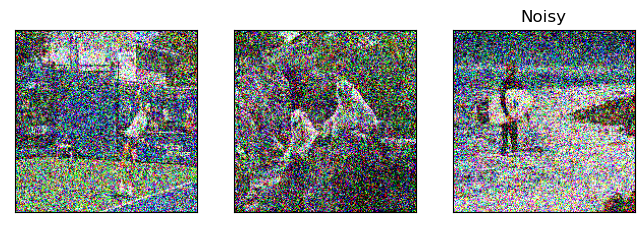

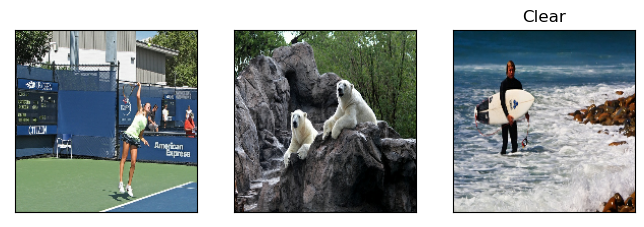

In [11]:
display_image(x_train, 3, 'Noisy')
display_image(y_train, 3, 'Clear')

### Model

In [12]:
def save_model_scores(model_name, optimizer, loss, history):
    filepath = os.path.join(ROOT, f"{PROJECT}.csv")

    exists = os.path.exists(filepath)

    with open(filepath, 'a', newline='') as file:
        writer = csv.writer(file)

        if not exists:
            header = ["model", "optimizer", "loss", "noise_factor", "seed", "batch_size", "epoch", "train_loss",
                      "val_loss", "train_accuracy", "val_accuracy", "train_ssim", "val_ssim"]
            writer.writerow(header)

        for i in range(len(history.history["loss"])):
            row = [
                str(model_name),
                str(optimizer),
                str(loss),
                float(NOISE_FACTOR),
                int(SEED),
                int(BATCH_SIZE),
                str(f"{i + 1}/{NB_EPOCHS}"),
                float(history.history["loss"][i]),
                float(history.history["val_loss"][i]),
                float(history.history["accuracy"][i]),
                float(history.history["val_accuracy"][i]),
                float(history.history["ssim_loss"][i]),
                float(history.history["val_ssim_loss"][i]),
            ]
            writer.writerow(row)

In [12]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

#### Define model

In [13]:
autoencoder = keras.models.Sequential([
    layers.Input(shape=INPUT_SHAPE),

    # Encoder
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.ReLU(),

    layers.Dropout(0.2),

    # Decoder
    layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(filters=256, kernel_size=(5, 5), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),

    layers.ReLU(),

    layers.Conv2DTranspose(3, kernel_size=(3, 3), activation='sigmoid', padding='same'),
], name="autoencoder")

In [14]:
optimizer = "ADAM"
loss = "SSIM"

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=ssim_loss,
    metrics=['accuracy', ssim_loss],
)

#### Save model

In [16]:
import time

now = int(time.time() * 1000)

model_name = f"{PROJECT}_{now}"

model_checkpoint_path = os.path.join(ROOT, CHECKPOINTS_DIR, model_name)

os.mkdir(model_checkpoint_path)

In [17]:
autoencoder.save(os.path.join(model_checkpoint_path, "model.h5"))

#### Checkpoint callback

In [18]:
checkpoint_path = os.path.join(model_checkpoint_path, "checkpoint_{epoch}_{val_loss}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_ssim_loss',
    mode='min',
    save_weights_only=True,
    save_best_only=True
)

#### Early Stopping callback

In [15]:
print(PATIENCE)

400


In [20]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_ssim_loss',
    mode='min',
    patience=400,
    restore_best_weights=True
)

### Train

In [21]:
# Train the model
history = autoencoder.fit(
    tf.data.Dataset.zip((x_train, y_train)),
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=tf.data.Dataset.zip((x_test, y_test)),
    callbacks=[early_stopping_callback]
)

Epoch 1/1000
12/12 [==============================] - 31s 965ms/step - loss: 0.5944 - accuracy: 0.3253 - ssim_loss: 0.5944 - val_loss: 0.5617 - val_accuracy: 0.3258 - val_ssim_loss: 0.5617
Epoch 2/1000
12/12 [==============================] - 10s 798ms/step - loss: 0.5383 - accuracy: 0.4234 - ssim_loss: 0.5383 - val_loss: 0.5290 - val_accuracy: 0.2589 - val_ssim_loss: 0.5290
Epoch 3/1000
12/12 [==============================] - 10s 825ms/step - loss: 0.5035 - accuracy: 0.3473 - ssim_loss: 0.5035 - val_loss: 0.4907 - val_accuracy: 0.4224 - val_ssim_loss: 0.4907
Epoch 4/1000
12/12 [==============================] - 10s 835ms/step - loss: 0.4779 - accuracy: 0.3650 - ssim_loss: 0.4779 - val_loss: 0.4890 - val_accuracy: 0.4237 - val_ssim_loss: 0.4890
Epoch 5/1000
12/12 [==============================] - 10s 818ms/step - loss: 0.4691 - accuracy: 0.3859 - ssim_loss: 0.4691 - val_loss: 0.4611 - val_accuracy: 0.3661 - val_ssim_loss: 0.4611
Epoch 6/1000
12/12 [==============================] - 7

#### Save training

In [22]:
autoencoder.save_weights(os.path.join(model_checkpoint_path, "cp.ckpt"))

In [23]:
save_model_scores(model_name, optimizer, loss, history)

#### Show model statistics

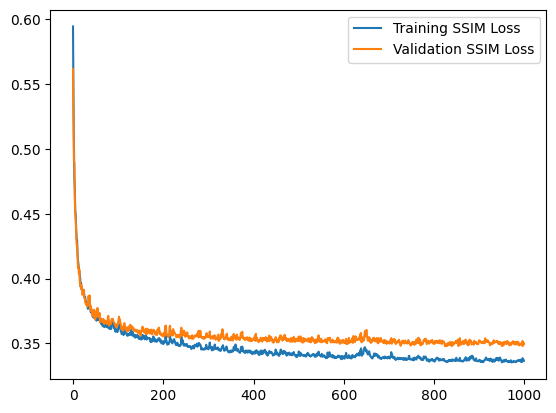

In [24]:
if history.history["ssim_loss"]:
    plt.plot(history.history["ssim_loss"], label="Training SSIM Loss")
    plt.plot(history.history["val_ssim_loss"], label="Validation SSIM Loss")
    plt.legend()

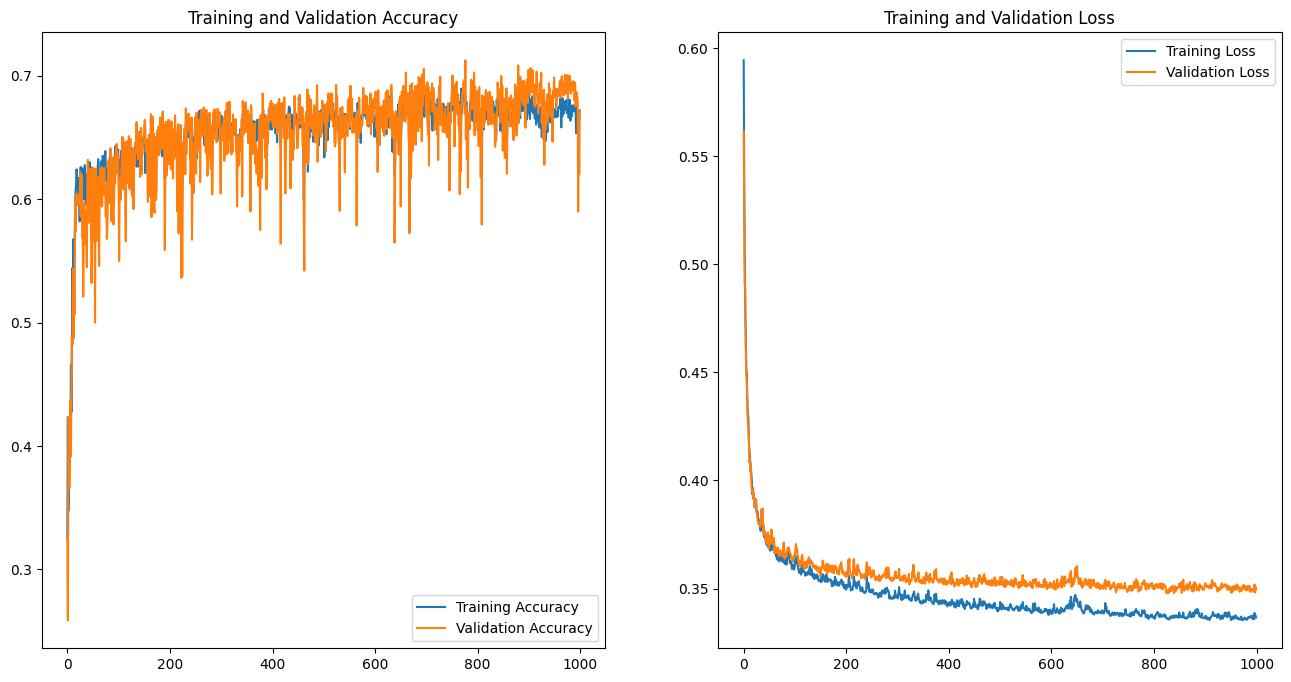

In [25]:
epochs_range = range(len(history.history['loss']))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [26]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 320, 320, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 128)     819328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 80, 80, 128)      0         
 2D)                                                             
                                                                 
 re_lu (ReLU)                (None, 80, 80, 128)       0         
                                                                 
 dropout (Dropout)           (None, 80, 80, 128)       

In [28]:
#visualkeras.layered_view(autoencoder, to_file=os.path.join(model_checkpoint_path, 'output.png')).show()  # write and show

### Reconstruction

In [29]:
def reconstruct(paths):
    clear_images = []
    noisy_images = []

    i = 0
    for path in paths:
        clear_images.append(load_image(tf.constant(path)))
        noisy_images.append(add_noise(clear_images[i]))
        i += 1

    decoded_images = autoencoder(np.array(noisy_images))

    return clear_images, noisy_images, decoded_images

In [31]:
clear_images, noisy_images, decoded_images = reconstruct([
    os.path.join(ROOT, 'img/painting_00002.jpg'),
    os.path.join(ROOT, 'img/painting_00001.jpg'),
    os.path.join(ROOT, 'img/painting_00001.jpg')
])

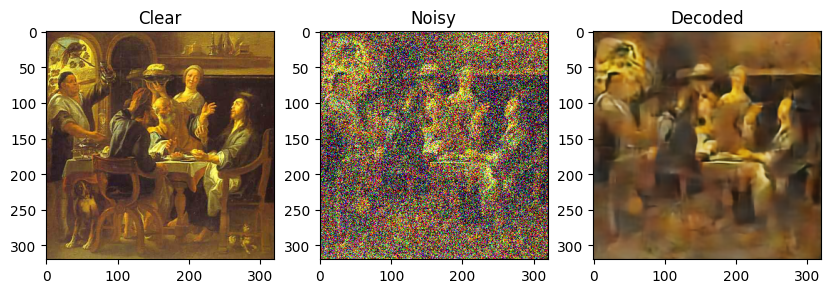

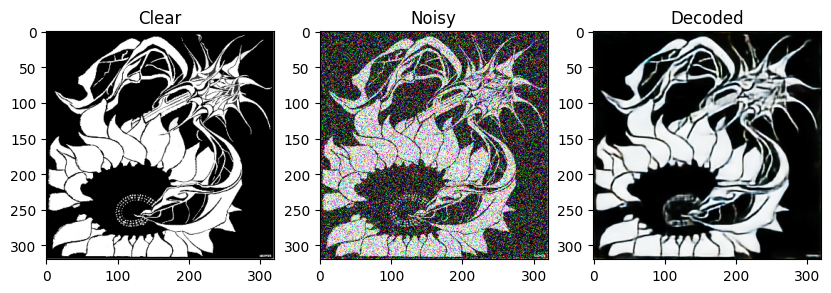

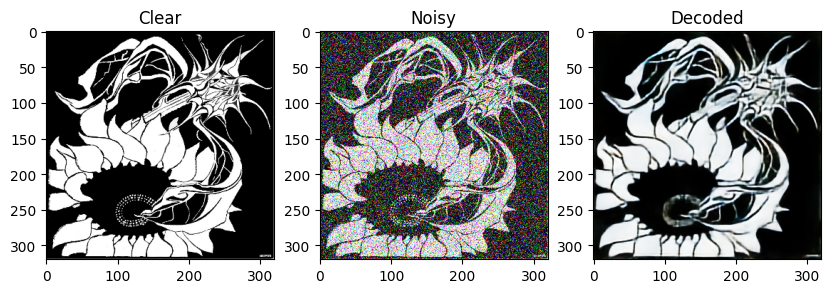

In [32]:
for i in range(len(decoded_images)):
    plt.figure(figsize=(10, 10))

    plt.subplot(131)
    plt.imshow(clear_images[i])
    plt.title('Clear')

    plt.subplot(132)
    plt.imshow(noisy_images[i])
    plt.title('Noisy')

    decoded = tf.clip_by_value(decoded_images[i], 0., 1.)

    plt.subplot(133)
    plt.imshow(decoded)
    plt.title('Decoded')

plt.show()

In [33]:
# reconstructions = autoencoder.predict(tf.expand_dims(img_noisy, axis=0))
# train_loss = tf.keras.losses.mae(reconstructions, x_train)
#
# plt.hist(train_loss[None,:], bins=50)
# plt.xlabel("Train loss")
# plt.ylabel("No of examples")
# plt.show()